# Analysis of 60 second Pseudo-Open Loop Phase Maps

In [1]:
## Import necessary modules

import matplotlib
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import os

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import savgol_filter, periodogram

from Wavefront import utils, wavefft

pylab.rcParams['figure.figsize'] = 16, 12

## Set directories for convenience
main_directory = '/nfs/slac/g/ki/ki19/lsst/snyder18'
data_directory = '/nfs/slac/g/ki/ki19/lsst/snyder18/Data'
results_directory = '/nfs/slac/g/ki/ki19/lsst/snyder18/Results'

/nfs/slac/g/ki/ki06/roodman/Software/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Currently the only 60 second time series files are from November 6th, 2015.  These are filtered out from the other data files, and any files yet to be run are simply skipped

In [2]:
## Get desired datasets using a list comprehension
all_subdirectories = os.listdir(results_directory)

subdirectories = [subdirectory for subdirectory in all_subdirectories if ("poldm" in subdirectory)
                  if ("GPI" in subdirectory)]

## Get the filepaths to the coefficients csv files
zernike_coefficient_datapaths = [os.path.join(results_directory, subdirectory, '{}_coefficients.csv'.format(subdirectory))
                                 for subdirectory in subdirectories]

datafile = []
Z_coefficients_all = []

## Read each csv file and make a list of the resulting NumPy arrays
for datapath in zernike_coefficient_datapaths:
    
    try:
        datafile.append(datapath)
        coefficients = np.loadtxt(datapath, dtype=np.float64, delimiter=',')
        Z_coefficients_all.append(coefficients)
    except IOError:
        pass
    
print len(Z_coefficients_all)

Z_coefficients = [Z_coefficients_all[0], Z_coefficients_all[10], Z_coefficients_all[11]]

14


In [3]:
simfile = simfile = 'aratmos_rate1000.0_exptime60.0_3layers.fits'
sim_dict = utils.filepath_library(simfile, main_directory, 'GPI')
sim_periodograms = np.loadtxt(sim_dict['periodograms'], dtype=np.float64, delimiter=',')
sim_coefficients = np.loadtxt(sim_dict['zernikes'], dtype=np.float64, delimiter=',')

## Standard Deviation Settling of Time-Averaged Zernikes

To study how the Zernike coefficients average out over differing averaging times, partition the time series into a series of $\Delta t$ length sections and calculate the average 

\begin{equation}
\frac{1}{\Delta t}\int_{t_k}^{\Delta t + t_k} Z_i(t) dt \approx \overline{Z}_i^{\Delta t}
\end{equation}

Then the RMS of the averaged Zernike coefficients is calculated as a function of $\Delta t$

In [4]:
## Define necessary auxilary functions

def settling(a_t, max_dt=2000, num_dt=100, is_smoothed=False):
    """From a time series of zernike coefficients, averages over intervals of dt
    and calculates the root-mean-square of the averages"""
    DT = np.arange(1, max_dt+2, 20, dtype=np.int32)
    DT[1:] = DT[1:]-1
    
    result = np.zeros(DT.shape[0])
    
    for i, dt in enumerate(DT):
       
        if is_smoothed:
    
            window = np.ones(int(dt))/float(dt)
            moving_avg = np.convolve(a_t, window, 'valid')
            result[i] = np.sqrt(np.mean(np.square(moving_avg)))
        
        else:
            num_int = a_t.shape[0]//dt
            reshaped = np.reshape(a_t[:num_int*dt], (num_int, dt))
            reshaped.mean(axis=1)
#            result[i] = np.sqrt(np.mean(np.square(reshaped.mean(axis=1))))
            result[i] = np.std(reshaped.mean(axis=1))
    
    return result, DT

The following code is used to calculate and show the RMS Zernike settling, expressed as

\begin{equation}
Z_\mathrm{rms}(\Delta t) = \sqrt{\frac{1}{N}\sum \left(\overline{Z}_i^{\Delta t}\right)^2}
\end{equation}

The following cell is used to show the RMS settling for every dataset, for a particular zernike $Z_\mathrm{Noll}$.

In [10]:
round(len(sim_coefficients[0])/(1000*10.))*1000.

6000.0

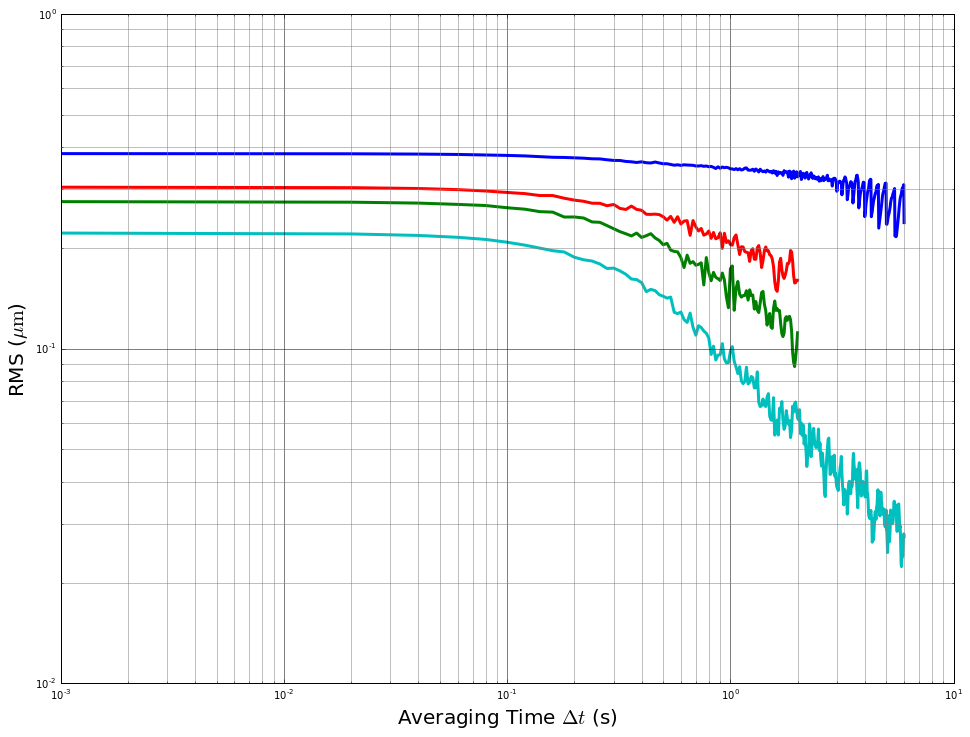

In [5]:
Z_noll = 5
rms = []
DT = []

## Data plotted
for Z_coefficient in Z_coefficients:
    max_dt = round(Z_coefficient.shape[1]/(1000*10.))*1000.
    rms_i, DT_i = settling(Z_coefficient[Z_noll-1,:], max_dt=max_dt)
    rms.append(rms_i)
    DT.append(DT_i)
    
for i in range(len(Z_coefficients)):
    
    if 'poldm' in subdirectories[i]:
        plt.loglog(DT[i]/1000., rms[i], linewidth=3.0)
    else:
        plt.loglog(DT[i]/1000., 0.5*rms[i]/(2*np.pi))
        
rms, DT = settling(sim_coefficients[Z_noll-1], max_dt=round(len(sim_coefficients[0])/(1000*10.))*1000.)

plt.loglog(DT/1000., 0.5*rms/(2*np.pi), linewidth=3.0)
    
#plt.title('RMS of $Z_{{{0}}}$ averaged over $\Delta t$'.format(Z_noll), fontsize=24)
plt.ylabel(r'RMS ($\mu\mathrm{m}$)', fontsize=20)
plt.xlabel(r'Averaging Time $\Delta t$ (s)', fontsize=20)
plt.minorticks_on()
plt.grid(b=True, which='major', color='black', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
#plt.legend(subdirectories, loc=3)
    
#plt.savefig('RMS_Z{}_dt_multiplot.png'.format(Z_noll))

The following cell will display the same graph for each of the first 10 Zernike terms (not including piston).

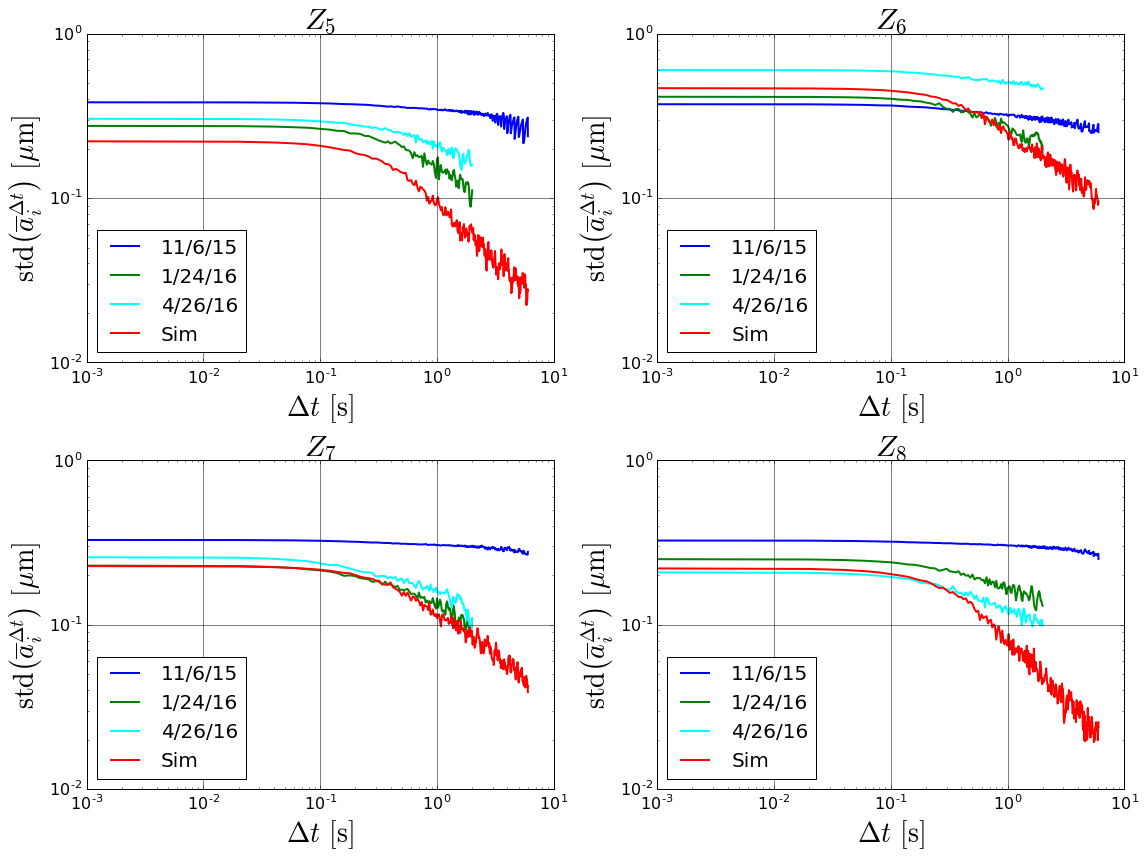

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2)
#fig.suptitle(r'RMS of $\langle Z_i \rangle$ for intervals of $\Delta t$ vs. $\Delta t$', fontsize=24)

colors = ['blue', 'green', 'cyan']

for i, ax in enumerate(axes.flatten()):
    
    z = i+5

    for j, Z_coefficient in enumerate(Z_coefficients):
        max_dt = round(Z_coefficient.shape[1]/(1000*10.))*1000.
        rms_i, DT_i = settling(Z_coefficient[z-1,:], max_dt=max_dt)
    
        img, = ax.loglog(DT_i/1000., rms_i, linewidth=2.0, color=colors[j])
        
    rms, DT = settling(sim_coefficients[z-1], max_dt=round(len(sim_coefficients[0])/(1000*10.))*1000.)
    ax.loglog(DT/1000., 0.5*rms/(2*np.pi), linewidth=2.0, color='red')
                
#    ax.legend(subdirectories, loc=3)
    ax.set_title(r'$Z_{{{}}}$'.format(z), fontsize=30)
    ax.minorticks_on()
    ax.grid(b=True, which='major', color='black', linestyle='-')
    ax.legend(['11/6/15', '1/24/16', '4/26/16', 'Sim'], 
               loc=3, fontsize=20)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
#    ax.grid(b=True, which='minor', color='grey', linestyle='-')

    ax.set_xlabel(r'$\Delta t$ $[\mathrm{s}]$', fontsize=28)
    ax.set_ylabel(r"$\mathrm{std}\left(\overline{a}_i^{\Delta t}\right)$ $[\mu \mathrm{m}]$", fontsize=28)

plt.tight_layout()
plt.savefig('mean_settling.png')

# High-Pass Filter on Zernike Time Series

IndexError: list index out of range

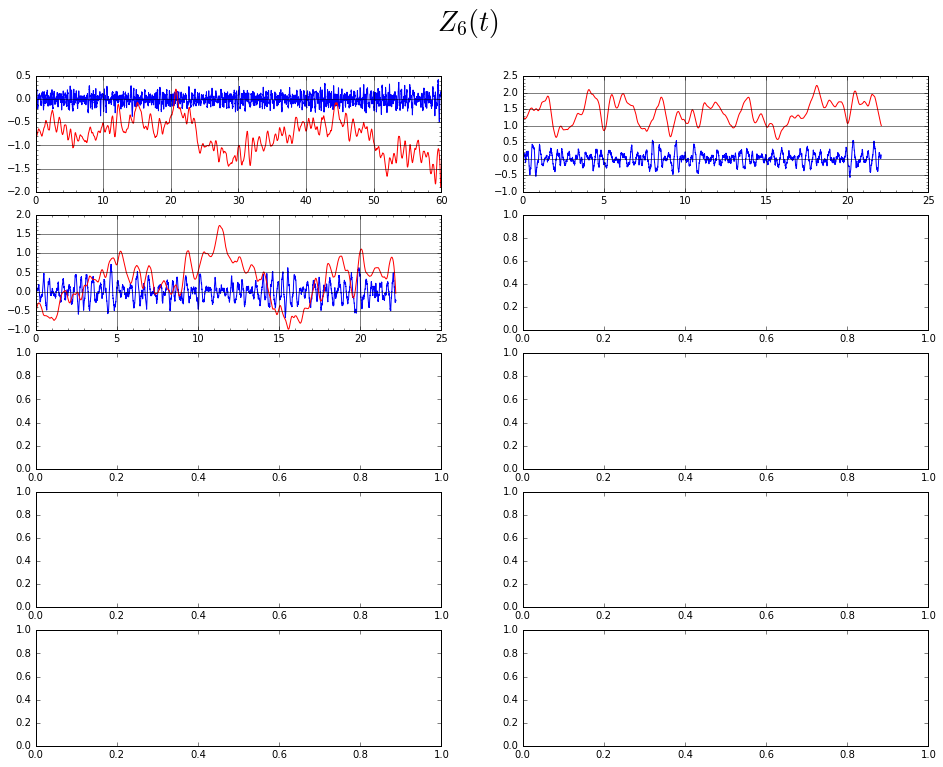

In [7]:
Z_noll = 6

poly_deg = 3
window = 801

## Initialize plot
fig, axes = plt.subplots(nrows=5, ncols=2)
fig.suptitle(r'$Z_{0}(t)$'.format(Z_noll), fontsize=28)

for i, ax in enumerate(axes.flatten()):
      
    T = np.arange(0, Z_coefficients[i].shape[1])/1000. 
    Z_lpf = savgol_filter(Z_coefficients[i][Z_noll-1,:], window, poly_deg)
    Z_hpf = Z_coefficients[i][Z_noll-1,:]-Z_lpf
        
    ## Plot original PSD, smoothed PSD, and linear fit
    img = ax.plot(T, Z_hpf, 'b', T, Z_lpf, 'r')
#    ax.legend(['Data', 'Simulation'], fontsize=14)
    ax.minorticks_on()
    ax.grid(b=True, which='major', color='black', linestyle='-')

## Set axis labels for shared axis
for ax in axes[3,:]:
    ax.set_xlabel('Time (s)', fontsize=22)
for ax in axes[:,0]:
    ax.set_ylabel(r'$a_{}$ ($\mu\mathrm{{m}}$)'.format(Z_noll), fontsize=22)

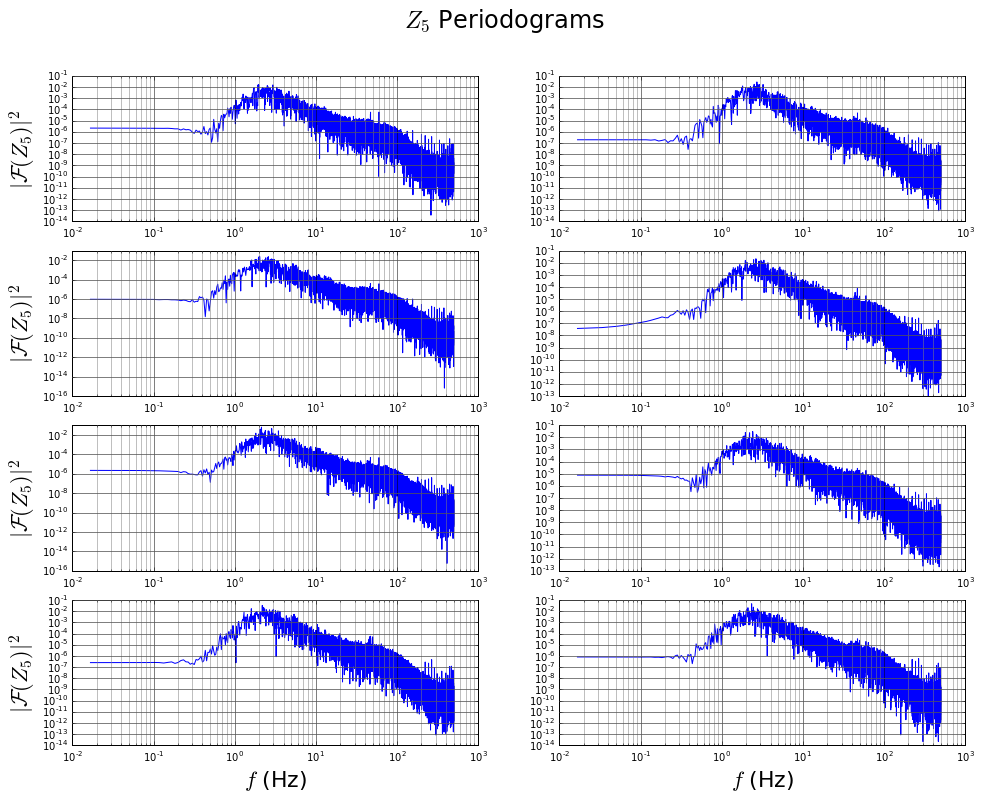

In [22]:
Z_noll = 5

fig, axes = plt.subplots(nrows=4, ncols=2)
fig.suptitle(r'$Z_{}$ Periodograms'.format(Z_noll), fontsize=24)

for i, ax in enumerate(axes.flatten()):
             
    ## Perform linear fit to smoothed PSD
#    par = np.polyfit(np.log10(K_list[i][K_list[i]>2.]), np.log10(PSD_list[i][noll_Z-1, K_list[i]>2]), 1)
#    slope = par[0]
#    intercept = par[1]
 
    Z_lpf = savgol_filter(Z_coefficients[i][Z_noll-1,:], window, poly_deg)
    Z_hpf = Z_coefficients[i][Z_noll-1,:]-Z_lpf
    
    ## Plot original PSD, smoothed PSD, and linear fit
    f, Pxx_spec = periodogram(Z_hpf, 1000.)
    
    img = ax.loglog(f[1:], Pxx_spec[1:])
#    ax.legend(['PSD', 'slope = {0:.2f}'.format(slope)], loc=3, fontsize=20)
#    img = ax.plot(np.log(K[1:]), slope*np.log(K[1:]) + intercept, 'g')

    ax.minorticks_on()
    ax.grid(b=True, which='major', color='black', linestyle='-')
    ax.grid(b=True, which='minor', color='grey', linestyle='-')
        
## Set axis labels for shared axis

## Set axis labels for shared axis
for ax in axes[3,:]:
    ax.set_xlabel(r'$f$ (Hz)', fontsize=22)
for ax in axes[:,0]:
    ax.set_ylabel(r"$|\mathcal{{F}}(Z_{0})|^2$".format(Z_noll), fontsize=22)

## Zernike Periodograms

As of the last update, the Zernike periodograms are now calculated at the same time as the Zernike time-series, so now it is necessary to read them from file

In [8]:
## Get desired datasets using a list comprehension
all_subdirectories2 = os.listdir(results_directory)

subdirectories2 = [subdirectory for subdirectory in all_subdirectories2 if ("aored" in subdirectory)
                  if ("GPI" in subdirectory)]

## Get the filepaths to the coefficients csv files
zernike_periodograms_datapaths = [os.path.join(results_directory, subdirectory, '{}_periodograms.csv'.format(subdirectory))
                                 for subdirectory in subdirectories]

datafile2 = []
Z_periodograms_all = []
Z_frequencies = []

## Read each csv file and make a list of the resulting NumPy arrays
for datapath in zernike_periodograms_datapaths:
    
    try:
        datafile2.append(datapath)
        data = np.loadtxt(datapath, dtype=np.float64, delimiter=',')
        Z_frequencies.append(data[0,:])
        Z_periodograms_all.append(data[1:,:])
    except IOError:
        pass

Z_periodograms = [Z_periodograms_all[0], Z_periodograms_all[10], Z_periodograms_all[11]]

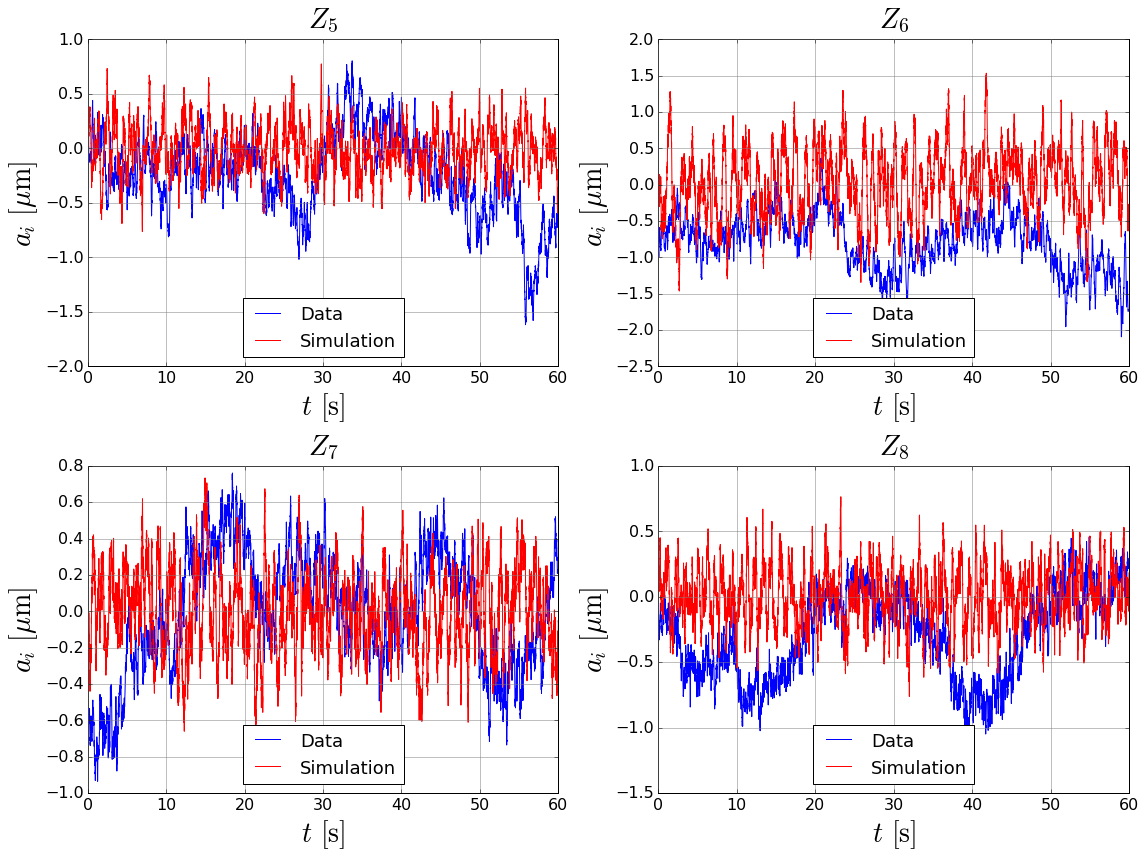

In [9]:
Z_noll_start = 5

fig, axes = plt.subplots(nrows=2, ncols=2)
#fig.suptitle(r'Data and Simulation Comparison', fontsize=26)

T_data = np.arange(0, Z_coefficients[0].shape[1])/1000.
T_sim = np.arange(0, sim_coefficients.shape[1])/1000.

for i, ax in enumerate(axes.flatten()):
      
    ## Plot original PSD, smoothed PSD, and linear fit
    img = ax.plot(T_data, Z_coefficients[0][Z_noll_start-1+i, :], 'b',
                  T_sim, 0.5*sim_coefficients[Z_noll_start-1+i, :]/(2*np.pi), 'r')
    ax.legend(['Data', 'Simulation'], 
               loc=8, fontsize=18)
    ax.set_title(r'$Z_{{{0}}}$'.format(Z_noll_start+i), fontsize=28, y=1.02)
    ax.grid(b=True, which='major', linestyle = '-', color = 'grey')
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
        
## Set axis labels for shared axis
    ax.set_xlabel(r'$t$ $\mathrm{[s]}$', fontsize=28)
    ax.set_ylabel(r'$a_i \,\, [\mu\mathrm{{m}}]$', fontsize=28)

plt.tight_layout()
plt.savefig('data_sim_Z_comp.png')

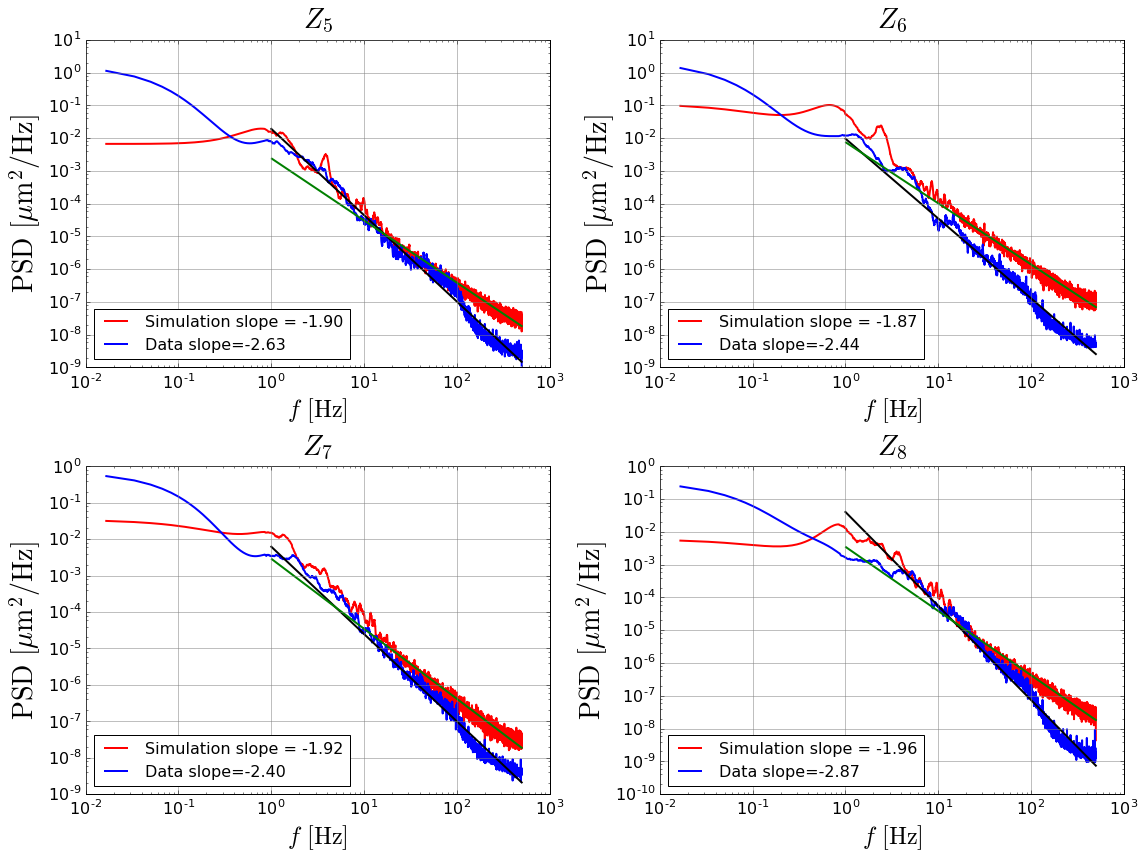

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2)
#fig.suptitle(r'Data and Simulation Comparison', fontsize=26)

Z_frequency = Z_frequencies[0][1:]
sim_frequency = sim_periodograms[0,1:]

for i, ax in enumerate(axes.flatten()):
    
    smoothed = 10**savgol_filter(np.log10(Z_periodograms[0][Z_noll_start-1+i,1:]), 101, 5)
    
    ## Perform linear fit to smoothed PSD
    par = np.polyfit(np.log10(Z_frequency[Z_frequency>1.]), np.log10(smoothed[Z_frequency>1.]), 1)
    slope = par[0]
    intercept = par[1]
    
    sim_smoothed = 10**savgol_filter(np.log10(sim_periodograms[Z_noll_start+i,1:]), 101, 5)
    sim_par = np.polyfit(np.log10(sim_frequency[sim_frequency>1]), 
                         np.log10(((0.5/(2*np.pi))**2)*sim_smoothed[sim_frequency>1.]), 1)
    sim_slope = sim_par[0]
    sim_intercept = sim_par[1]
    
    ## Plot original PSD, smoothed PSD, and linear fit
    img = ax.loglog(sim_frequency, ((0.5/(2*np.pi))**2)*sim_smoothed, 'r',
                    Z_frequency, smoothed, 'b',
                    Z_frequency[Z_frequency>1.], (10**intercept)*Z_frequency[Z_frequency>1.]**slope, 'black',
                    sim_frequency[sim_frequency>1.], 
                    (10**sim_intercept)*sim_frequency[sim_frequency>1.]**sim_slope, 'green', linewidth=2.0)
    ax.legend(['Simulation slope = {0:.2f}'.format(sim_slope),
               'Data slope={0:.2f}'.format(slope)], 
               loc=3, fontsize=16)
    ax.set_title(r'$Z_{{{0}}}$'.format(Z_noll_start+i), fontsize=28, y=1.02)
    ax.grid(b=True, which='major', color='grey', linestyle='-')
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
        
## Set axis labels for shared axis
    ax.set_xlabel(r'$f$ $\mathrm{[Hz]}$', fontsize=24)
    ax.set_ylabel(r'$\mathrm{{PSD}} \,\, [\mu\mathrm{{m}}^2/\mathrm{{Hz}}]$', fontsize=28)

plt.tight_layout()
#plt.savefig('data_sim_psd_comp.png')